# Sktime: Usando a API do scikit learn pra previsão de séries temporais

A ideia do sktime é ter uma interface modularizável e similar ao do scikit learn, mas que leve em conta as especificidades de séries temporais (por exemplo, o ordenamento temporal).

## Dataset de teste: número de passageiros em voos internacionais como função do tempo

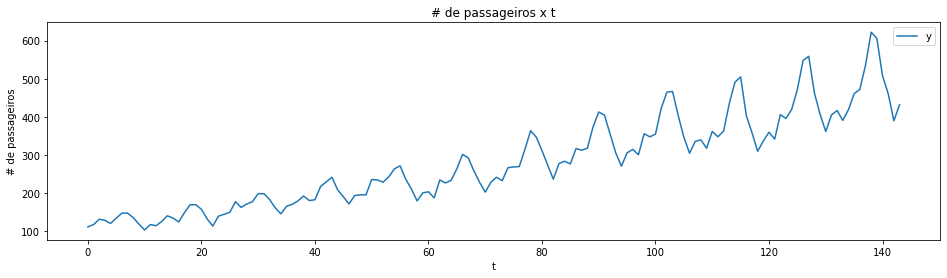

In [1]:
#pip install sktime
#https://github.com/alan-turing-institute/sktime/tree/master/examples

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.datasets import load_airline
from sktime.utils.plotting.forecasting import plot_ys

y = load_airline()
fig, ax = plot_ys(y,labels=['y']);
ax.set_title('# de passageiros x t')
ax.set_xlabel('t')
ax.set_ylabel('# de passageiros')
plt.show()

## Divisão treino / teste

É simples dividir os dados em treino e teste levando em consideração a estrutura temporal usando o sktime.

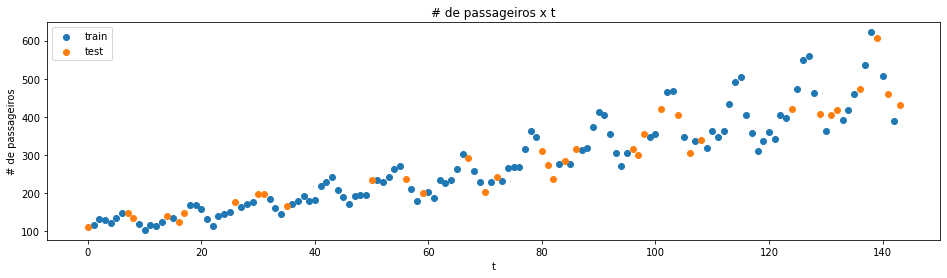

In [2]:
#Divisão ingênua com o sklearn

from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)

fig, ax = plot_ys(y_train,y_test,labels=['train','test']);
ax.set_title('# de passageiros x t')
ax.set_xlabel('t')
ax.set_ylabel('# de passageiros')
plt.show()

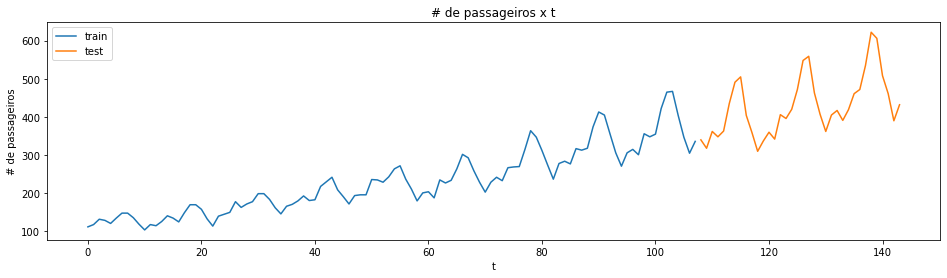

In [3]:
#Divisão certa com o sktime

from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y)

fig, ax = plot_ys(y_train,y_test,labels=['train','test']);
ax.set_title('# de passageiros x t')
ax.set_xlabel('t')
ax.set_ylabel('# de passageiros')
plt.show()

## Criando baselines simples 

O sktime fornece estimadores ingênuos com métodos .fit / .predict de maneira similar ao sklearn.

In [4]:
from sktime.forecasting.naive import NaiveForecaster

nf_last = NaiveForecaster(strategy='last')
nf_mean = NaiveForecaster(strategy='mean')
nf_seasonal_last = NaiveForecaster(strategy='seasonal_last', 
                                   sp = 12) #sazonalidade anual

nf_last.fit(y_train)
nf_mean.fit(y_train)
nf_seasonal_last.fit(y_train);

Pra fazer a predição precisamos de um horizonte de predição (forecasting horizon, fh). O sktime guarda o último índice e adiciona como um offset na hora de fazer a predição. Assim, só precisamos criar um grid de 1, 2, 3 ... até quantos meses a diante quisermos prever.

In [5]:
fh = np.arange(len(y_test))+1

As predições então podem ser plotadas de maneira fácil igual fizemos com os dados de treino e teste.

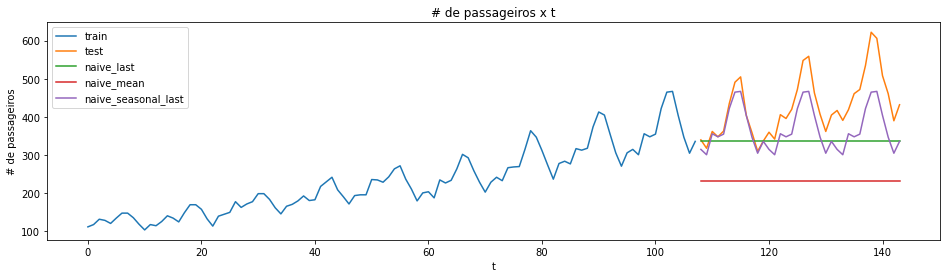

In [6]:
y_pred=dict()

y_pred['naive_last']=nf_last.predict(fh)
y_pred['naive_mean']=nf_mean.predict(fh)
y_pred['naive_seasonal_last']=nf_seasonal_last.predict(fh)

labels = ['train','test']+[*y_pred.keys()]

fig, ax = plot_ys(y_train,y_test,*y_pred.values(),labels=labels)
ax.set_title('# de passageiros x t')
ax.set_xlabel('t')
ax.set_ylabel('# de passageiros')
plt.show()

## Métricas

O sktime também fornece algumas métricas próprias de séries temporais pra computarmos o quão boas são nossas predições. Em particular, temos

- sMAPE $=\frac{2}{n} \sum_{t=1}^n \frac{|v_t - p_t|}{|v_t|+|p_t|}$

In [7]:
from sktime.performance_metrics.forecasting import smape_loss

for pred in y_pred.keys():
    print(f'sMAPE pro método {pred} = {100*smape_loss(y_test,y_pred[pred]):.2f}%')

sMAPE pro método naive_last = 23.20%
sMAPE pro método naive_mean = 58.06%
sMAPE pro método naive_seasonal_last = 14.54%


In [8]:
# Também podemos usar as métricas do sklearn

from sklearn.metrics import mean_squared_error

for pred in y_pred.keys():
    print(f'RMSE pro método {pred} = {np.sqrt(mean_squared_error(y_test,y_pred[pred])):.2f}')

RMSE pro método naive_last = 121.14
RMSE pro método naive_mean = 212.52
RMSE pro método naive_seasonal_last = 73.61


## Tirar tendências e sazonalidade

Antes de modelar podemos usar os transformers do sktime pra tirar tendências e sazonalidade.

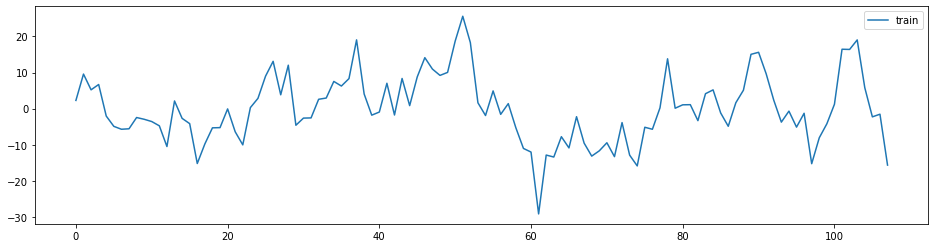

In [9]:
from sktime.transformers.single_series.detrend import Detrender, Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
# from sktime.transformers.single_series.boxcox import BoxCoxTransformer

# bx = BoxCoxTransformer()
ds = Deseasonalizer(sp=12,model='multiplicative')
ptf = PolynomialTrendForecaster(degree=2)
dt = Detrender(ptf)

y_train_transformed=dt.fit_transform(ds.fit_transform(y_train))
plot_ys(y_train_transformed,labels=['train']);

## Predição com modelos clássicos

Podemos combinar os passos anteriores em um pipeline (assim como no sklearn) e usar um estimador pra prever os valores da série. Vamos tomar como exemplos o AutoARIMA e suavização exponencial.

/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


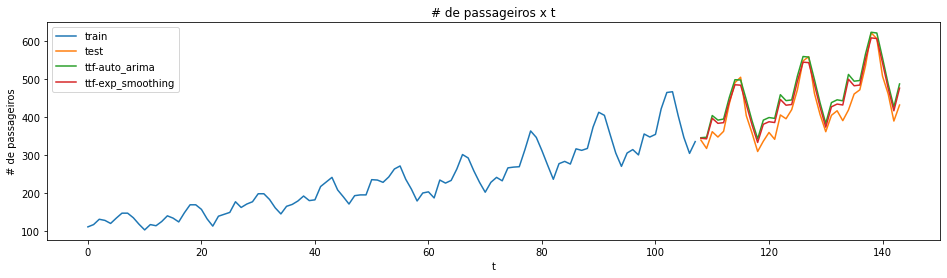

In [10]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

#Montando um 'pipeline'
from sktime.forecasting.compose import TransformedTargetForecaster

auto_arima = AutoARIMA()
steps=[('deseasonalizer',ds),('detrender',dt),('auto_arima',auto_arima)]

ttf_1 = TransformedTargetForecaster(steps)

ttf_1.fit(y_train)
y_pred['ttf-auto_arima'] = ttf_1.predict(fh)

exp_smoothing = ExponentialSmoothing()
steps=[('deseasonalizer',ds),('detrender',dt),('exp_smoothing',exp_smoothing)]

ttf_2 = TransformedTargetForecaster(steps)

ttf_2.fit(y_train)
y_pred['ttf-exp_smoothing'] = ttf_2.predict(fh)

fig, ax = plot_ys(y_train,y_test,y_pred['ttf-auto_arima'],y_pred['ttf-exp_smoothing'],
                  labels=['train','test','ttf-auto_arima','ttf-exp_smoothing']);
ax.set_title('# de passageiros x t')
ax.set_xlabel('t')
ax.set_ylabel('# de passageiros')
plt.show()

In [11]:
#Melhoramos algo? Sim!

print(f'{100*smape_loss(y_test,y_pred["ttf-auto_arima"]):.2f}%')

print(f'{100*smape_loss(y_test,y_pred["ttf-exp_smoothing"]):.2f}%')

7.81%
5.87%


# Usando modelos do sklearn junto com o sktime

Vamos usar uma random forest pra fazer uma autoregressão.

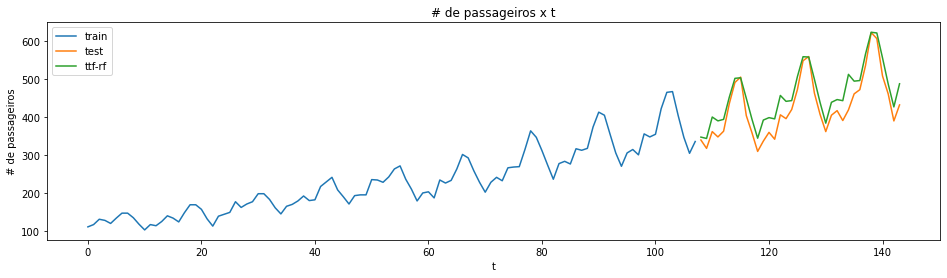

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sktime.forecasting.compose import RecursiveRegressionForecaster

skl_regressor=LinearRegression()
rrf = RecursiveRegressionForecaster(regressor=skl_regressor,window_length=12)

steps=[('deseasonalizer',ds),('detrender',dt),('rrf',rrf)]

ttf_rf = TransformedTargetForecaster(steps)

ttf_rf.fit(y_train)
y_pred['ttf-rf'] = ttf_rf.predict(fh)

fig, ax = plot_ys(y_train,y_test,y_pred['ttf-rf'],labels=['train','test','ttf-rf']);
ax.set_title('# de passageiros x t')
ax.set_xlabel('t')
ax.set_ylabel('# de passageiros')
plt.show()

In [13]:
print(f'{100*smape_loss(y_test,y_pred["ttf-rf"]):.2f}%')

6.65%


# Sktime pra outros problemas com séries temporais, por exemplo, classificação.

A biblioteca do sktime também tem alguns datasets e algoritmos próprios pra classificação de séries temporais.

In [15]:
from sktime.datasets import load_basic_motions

X, y = load_basic_motions(return_X_y=True)

y.unique()

array(['standing', 'running', 'walking', 'badminton'], dtype=object)

In [16]:
X.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5
0,0 0.079106 1 0.079106 2 -0.903497 3...,0 0.394032 1 0.394032 2 -3.666397 3...,0 0.551444 1 0.551444 2 -0.282844 3...,0 0.351565 1 0.351565 2 -0.095881 3...,0 0.023970 1 0.023970 2 -0.319605 3...,0 0.633883 1 0.633883 2 0.972131 3...
1,0 0.377751 1 0.377751 2 2.952965 3...,0 -0.610850 1 -0.610850 2 0.970717 3...,0 -0.147376 1 -0.147376 2 -5.962515 3...,0 -0.103872 1 -0.103872 2 -7.593275 3...,0 -0.109198 1 -0.109198 2 -0.697804 3...,0 -0.037287 1 -0.037287 2 -2.865789 3...
2,0 -0.813905 1 -0.813905 2 -0.424628 3...,0 0.825666 1 0.825666 2 -1.305033 3...,0 0.032712 1 0.032712 2 0.826170 3...,0 0.021307 1 0.021307 2 -0.372872 3...,0 0.122515 1 0.122515 2 -0.045277 3...,0 0.775041 1 0.775041 2 0.383526 3...
3,0 0.289855 1 0.289855 2 -0.669185 3...,0 0.284130 1 0.284130 2 -0.210466 3...,0 0.213680 1 0.213680 2 0.252267 3...,0 -0.314278 1 -0.314278 2 0.018644 3...,0 0.074574 1 0.074574 2 0.007990 3...,0 -0.079901 1 -0.079901 2 0.237040 3...
4,0 -0.123238 1 -0.123238 2 -0.249547 3...,0 0.379341 1 0.379341 2 0.541501 3...,0 -0.286006 1 -0.286006 2 0.208420 3...,0 -0.098545 1 -0.098545 2 -0.023970 3...,0 0.058594 1 0.058594 2 0.175783 3...,0 -0.074574 1 -0.074574 2 0.114525 3...


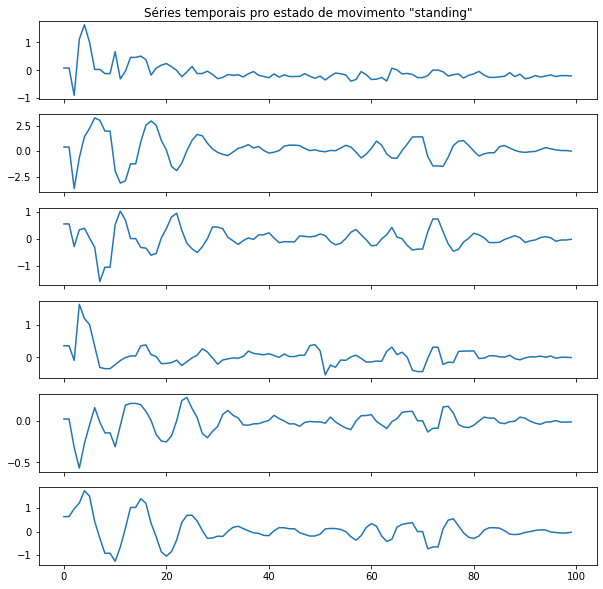

In [17]:
fig, ax = plt.subplots(6,sharex=True,figsize=(10,10))
plt.suptitle(f'Séries temporais pro estado de movimento "{y.iloc[0]}"',y=0.9)

for i, series in enumerate(X.iloc[0]):
    ax[i].plot(series,label=f'dim_{i}')
    
plt.show()

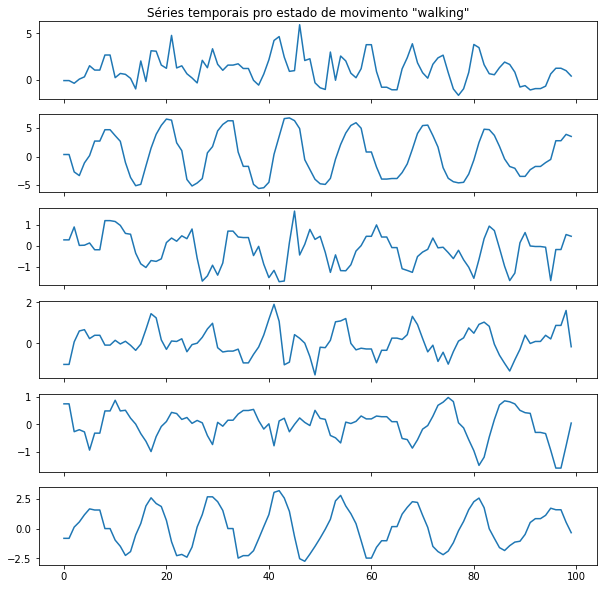

In [18]:
fig, ax = plt.subplots(6,sharex=True,figsize=(10,10))
plt.suptitle(f'Séries temporais pro estado de movimento "{y.iloc[20]}"',y=0.9)

for i, series in enumerate(X.iloc[20]):
    ax[i].plot(series)
    
plt.show()

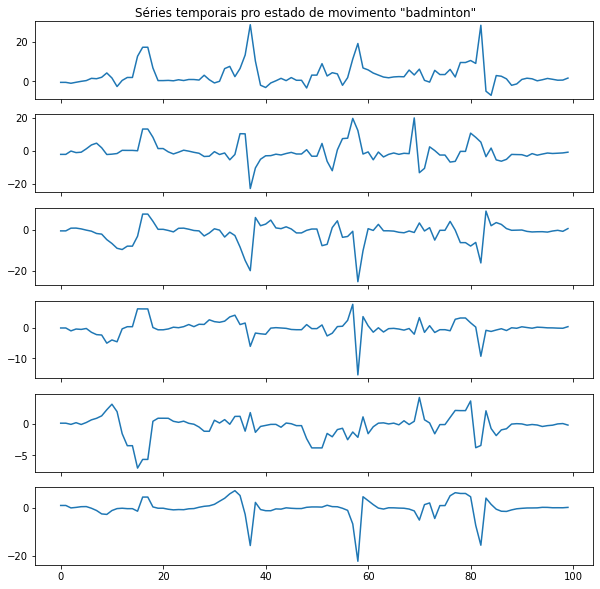

In [19]:
fig, ax = plt.subplots(6,sharex=True,figsize=(10,10))
plt.suptitle(f'Séries temporais pro estado de movimento "{y.iloc[70]}"',y=0.9)

for i, series in enumerate(X.iloc[70]):
    ax[i].plot(series)
    
plt.show()

In [20]:
from sktime.transformers.series_as_features.compose import ColumnConcatenator
from sktime.classification.compose import TimeSeriesForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X_train, X_test, y_clf_train, y_clf_test = train_test_split(X,y,stratify=y)

steps = [
    ('concatenate', ColumnConcatenator()),
    ('classify', TimeSeriesForestClassifier(n_estimators=50))]

clf = Pipeline(steps)
clf.fit(X_train, y_clf_train)
clf.score(X_test, y_clf_test)

1.0

# Cross-validation com o sktime

O sktime também permite fazer validação cruzada temporal e busca de parâmetros com um gridsearch.

In [21]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter

nf = NaiveForecaster()
param_grid = {"strategy": ['last','mean']}

cv = SlidingWindowSplitter(initial_window=12,start_with_window=True)
gscv = ForecastingGridSearchCV(nf, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred['gscv'] = gscv.predict(fh)

gscv.best_params_

{'strategy': 'last'}

In [22]:
from sklearn.neighbors import KNeighborsRegressor

skl_regressor=KNeighborsRegressor()
rrf = RecursiveRegressionForecaster(regressor=skl_regressor,window_length=12)

steps=[('deseasonalizer',ds),('detrender',dt),('rrf',rrf)]

ttf_rf = TransformedTargetForecaster(steps)

param_grid = {"rrf__regressor__n_neighbors": [1,3,5,7],"rrf__regressor__p":[1,2]}

cv = SlidingWindowSplitter(initial_window=24,start_with_window=True)
gscv = ForecastingGridSearchCV(ttf_rf, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred['gscv'] = gscv.predict(fh)

gscv.best_params_

{'rrf__regressor__n_neighbors': 1, 'rrf__regressor__p': 2}

In [23]:
gscv.cv_results_

{'mean_fit_time': array([0.02903152, 0.02258396, 0.0240519 , 0.02773809, 0.0158639 ,
        0.02304363, 0.02638531, 0.02355051]),
 'mean_score_time': array([1.42521691, 1.3414607 , 1.34187603, 1.29932261, 1.31033301,
        1.32647872, 1.27880645, 1.33202028]),
 'param_rrf__regressor__n_neighbors': masked_array(data=[1, 1, 3, 3, 5, 5, 7, 7],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_rrf__regressor__p': masked_array(data=[1, 2, 1, 2, 1, 2, 1, 2],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'rrf__regressor__n_neighbors': 1, 'rrf__regressor__p': 1},
  {'rrf__regressor__n_neighbors': 1, 'rrf__regressor__p': 2},
  {'rrf__regressor__n_neighbors': 3, 'rrf__regressor__p': 1},
  {'rrf__regressor__n_neighbors': 3, 'rrf__regressor__p': 2},
  {'rrf__regressor__n_neighbors': 5, 'rrf__regressor__p': 1},
  {'

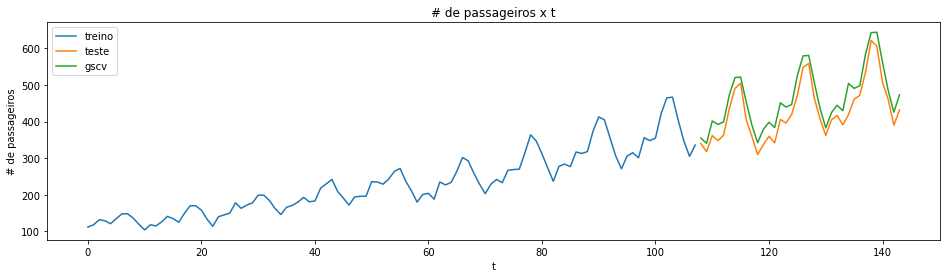

In [24]:
fig, ax = plot_ys(y_train,y_test,y_pred['gscv'],labels=['treino','teste','gscv']);
ax.set_title('# de passageiros x t')
ax.set_xlabel('t')
ax.set_ylabel('# de passageiros')
plt.show()

In [25]:
for pred in y_pred.keys():
    print(f'sMAPE pro método {pred} = {100*smape_loss(y_test,y_pred[pred]):.2f}%')

sMAPE pro método naive_last = 23.20%
sMAPE pro método naive_mean = 58.06%
sMAPE pro método naive_seasonal_last = 14.54%
sMAPE pro método ttf-auto_arima = 7.81%
sMAPE pro método ttf-exp_smoothing = 5.87%
sMAPE pro método ttf-rf = 7.71%
sMAPE pro método gscv = 8.18%


# Alternativa: Darts

In [26]:
#pip install u8darts
#https://github.com/unit8co/darts/tree/master/examples

from darts import TimeSeries
from darts.models import ExponentialSmoothing

y=load_airline()
idx = pd.date_range(start='01-01-1949',end='01-01-1961',freq='M')
y.index=idx
y=TimeSeries.from_series(y)

y_train, y_test = y.split_before(pd.Timestamp('01-01-1958'))

model = ExponentialSmoothing()
model.fit(y_train)
prediction = model.predict(len(y_test))

/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


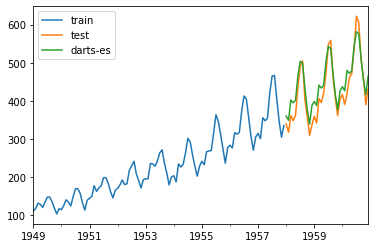

In [27]:
y_train.plot(label='train')
y_test.plot(label='test')
prediction.plot(label='darts-es')
plt.legend();

In [28]:
from darts.models import RNNModel
from darts.preprocessing import ScalerWrapper

wrapper = ScalerWrapper()
y_train_transformed = wrapper.fit_transform(y_train)
y_test_transformed = wrapper.transform(y_test)
y_transformed = wrapper.transform(y)

rnn_model = RNNModel(
    model ='LSTM',
    output_length=1,
    hidden_size=25
    ,
    n_rnn_layers=2,
    input_length=12,
    batch_size=16,
    n_epochs=500,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='RNN', log_tensorboard=True
)

rnn_model.fit(y_train_transformed,verbose=True)

/home/gabriel/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Training loss: 0.0056


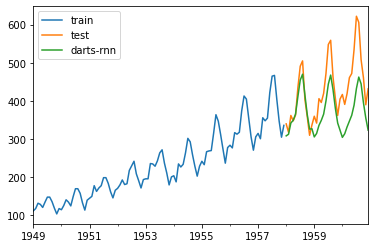

In [29]:
prediction=rnn_model.predict(len(y_test))

y_train.plot(label='train')
y_test.plot(label='test')
wrapper.inverse_transform(prediction).plot(label='darts-rnn')
plt.legend();